<a href="https://colab.research.google.com/github/saniyaverma/Crop-Disease-Prediction-Models-analysis/blob/v1/Tomato_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import os
import json
import shutil
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [29]:
# Upload your kaggle.json first in Colab (use sidebar)

with open("kaggle.json", "r") as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentials["key"]

!kaggle datasets download -d kaustubhb999/tomatoleaf
!unzip -q tomatoleaf.zip

Dataset URL: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf
License(s): CC0-1.0
tomatoleaf.zip: Skipping, found more recently modified local copy (use --force to force download)
replace tomato/cnn_train.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tomato/train/Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tomato/train/Tomato___Bacterial_spot/01375198-62af-4c40-bddf-f3c11107200b___GCREC_Bact.Sp 5914.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tomato/train/Tomato___Bacterial_spot/05777829-6912-44bb-bcef-901bc5190584___GCREC_Bact.Sp 6150.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tomato/train/Tomato___Bacterial_spot/070228e2-ba4e-4de8-813b-074e51ed6f5a___UF.GRC_BS_Lab Leaf 0661.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [30]:
# Combine train and val folders into one
combined_path = "/content/tomato-leaf-disease"
train_path = "/content/tomato/train"
val_path = "/content/tomato/val"
os.makedirs(combined_path, exist_ok=True)

def combine_folders(source_dir, target_dir):
    for cls in os.listdir(source_dir):
        src_cls = os.path.join(source_dir, cls)
        dst_cls = os.path.join(target_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for file in os.listdir(src_cls):
            shutil.copy2(os.path.join(src_cls, file), os.path.join(dst_cls, file))

combine_folders(train_path, combined_path)
combine_folders(val_path, combined_path)

In [31]:
def count_images(folder_path):
    total = 0
    for cls in sorted(os.listdir(folder_path)):
        path = os.path.join(folder_path, cls)
        count = len(os.listdir(path))
        print(f"{cls}: {count} images")
        total += count
    print(f"\nTotal images: {total}")

count_images(combined_path)

def check_image_integrity(folder_path):
    broken = []
    for cls in os.listdir(folder_path):
        for img in os.listdir(os.path.join(folder_path, cls)):
            try:
                with Image.open(os.path.join(folder_path, cls, img)) as im:
                    im.verify()
            except:
                broken.append(os.path.join(cls, img))
    print("Corrupt images:" if broken else "All images OK")
    if broken: print(broken)

check_image_integrity(combined_path)

Tomato___Bacterial_spot: 1100 images
Tomato___Early_blight: 1100 images
Tomato___Late_blight: 1100 images
Tomato___Leaf_Mold: 1100 images
Tomato___Septoria_leaf_spot: 1100 images
Tomato___Spider_mites Two-spotted_spider_mite: 1100 images
Tomato___Target_Spot: 1100 images
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1100 images
Tomato___Tomato_mosaic_virus: 1100 images
Tomato___healthy: 1100 images

Total images: 11000
All images OK


In [32]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
SEED = 123

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    combined_path,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

class_names = full_ds.class_names
NUM_CLASSES = len(class_names)

# 80/10/10 split
total_batches = tf.data.experimental.cardinality(full_ds).numpy()
train_size = int(0.8 * total_batches)
val_size = int(0.1 * total_batches)

train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 11000 files belonging to 10 classes.


In [33]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [34]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_3 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_3 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [35]:
initial_epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs
)

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 101s 334ms/step - accuracy: 0.1823 - loss: 2.3317 - val_accuracy: 0.4881 - val_loss: 1.6425
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 87s 315ms/step - accuracy: 0.4805 - loss: 1.5638 - val_accuracy: 0.6379 - val_loss: 1.2743
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 91s 331ms/step - accuracy: 0.6080 - loss: 1.2253 - val_accuracy: 0.6930 - val_loss: 1.0863
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 93s 336ms/step - accuracy: 0.6658 - loss: 1.0614 - val_accuracy: 0.7215 - val_loss: 0.9924
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 93s 337ms/step - accuracy: 0.6958 - loss: 0.9462 - val_accuracy: 0.7399 - val_loss: 0.9176
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 91s 331ms/step - accuracy: 0.7235 - loss: 0.8733 - val_accuracy: 0.7711 - val_loss: 0.8311
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 86s 313ms/step - accuracy: 0.7438 - loss: 0.8142 - val_accuracy: 0.7785 - val_loss: 0.7896
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 85s 310ms/step - accuracy: 0.7613 - loss: 

In [36]:
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

fine_tune_epochs = 10bn
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1]
)

Epoch 10/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 118s 351ms/step - accuracy: 0.4866 - loss: 1.7018 - val_accuracy: 0.7178 - val_loss: 0.8358
Epoch 11/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 96s 349ms/step - accuracy: 0.7874 - loss: 0.6395 - val_accuracy: 0.7142 - val_loss: 0.8341
Epoch 12/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 94s 343ms/step - accuracy: 0.8387 - loss: 0.5074 - val_accuracy: 0.7537 - val_loss: 0.7211
Epoch 13/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 96s 349ms/step - accuracy: 0.8571 - loss: 0.4318 - val_accuracy: 0.7868 - val_loss: 0.5891
Epoch 14/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 89s 322ms/step - accuracy: 0.8870 - loss: 0.3630 - val_accuracy: 0.8529 - val_loss: 0.4343
Epoch 15/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 89s 322ms/step - accuracy: 0.8994 - loss: 0.3199 - val_accuracy: 0.8768 - val_loss: 0.3725
Epoch 16/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 89s 325ms/step - accuracy: 0.9053 - loss: 0.2898 - val_accuracy: 0.8998 - val_loss: 0.3207
Epoch 17/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 90s 324ms/step - accuracy: 0.9138 

In [37]:
acc = history.history['accuracy'] +history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] +  history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] +  history_fine.history['val_loss']

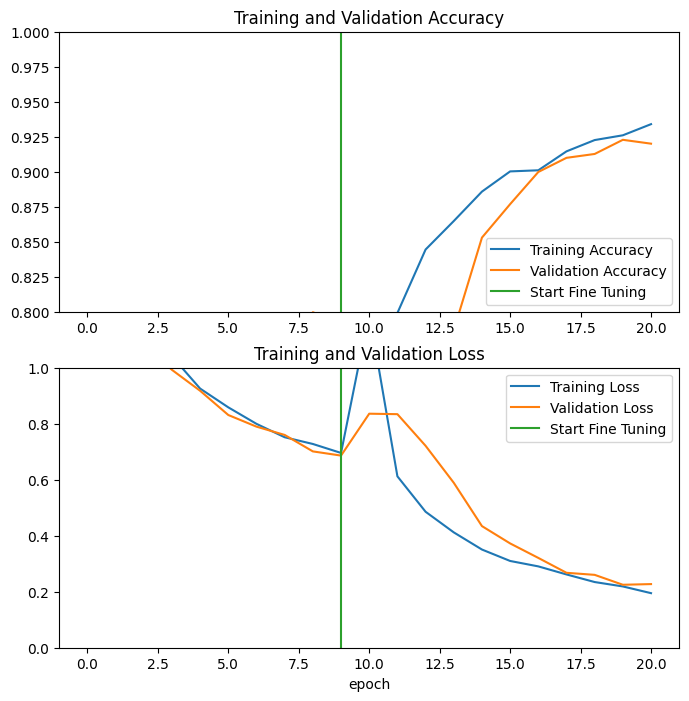

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━

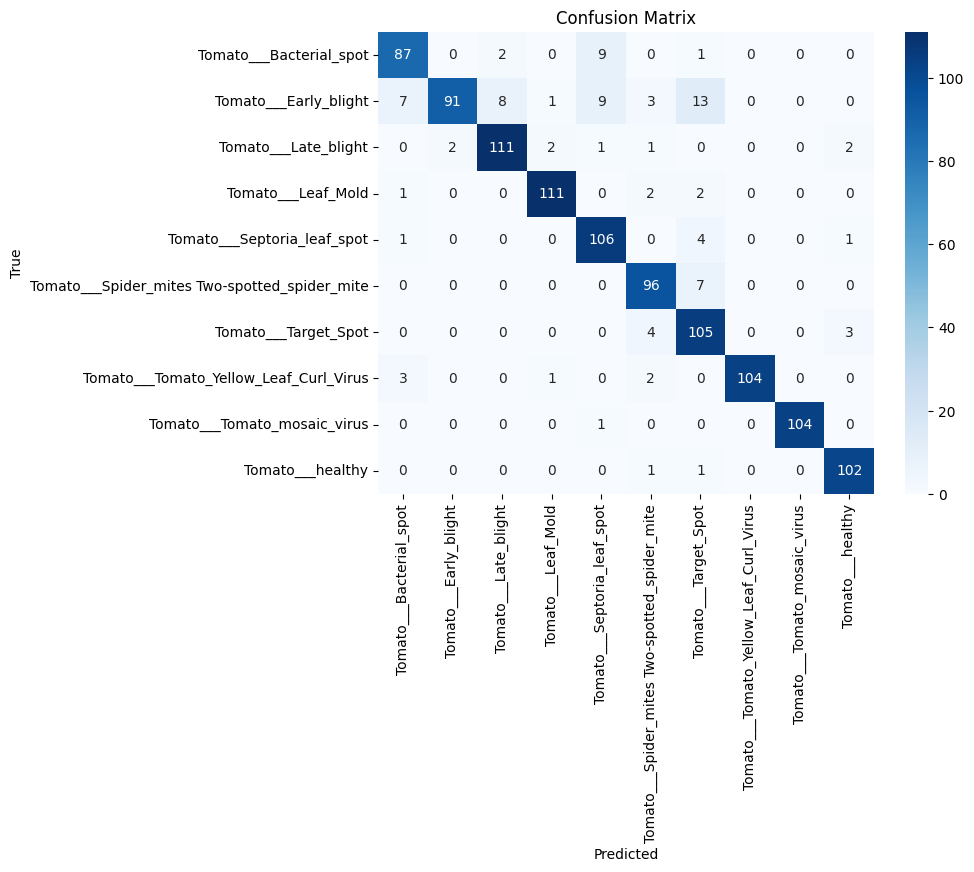

ROC-AUC Score: 99.70%


In [39]:
y_true, y_pred, y_prob = [], [], []

for images, labels in test_ds:
    preds = model.predict(images)
    y_prob.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

print(f"Accuracy: {accuracy_score(y_true, y_pred)*100:.2f}%")
print(f"Precision: {precision_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"Recall: {recall_score(y_true, y_pred, average='weighted')*100:.2f}%")
print(f"F1 Score: {f1_score(y_true, y_pred, average='weighted')*100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

try:
    auc_score = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"ROC-AUC Score: {auc_score*100:.2f}%")
except Exception as e:
    print("ROC-AUC not available:", e)

In [40]:
model.save("tomato-leaf-disease_MobileNet_model.keras")
print("Model saved successfully.")

Model saved successfully.
